In [23]:
import os

if "src" in os.getcwd():
    os.chdir("../")

from pathlib import Path

## Академия Аналитиков Авито 2024-2025

## Семинар по Audio Processing

<span style="font-size: 20px;">Цель: познакомиться с инструментами обработки звука.<br>Воспользоваться моделью **Whisper** для решения задачи распознавания речи.</span>

**Преимущества**:

- универсальность -- распознавание на 90+ языков; хорошо обобщается на данные разной природы т.к. видел много разнообразных данных на трейне
- многозадачность -- помимо задачи ASR умеет распознавать язык, определять границы речевых сегментов, переводить на английский
- для достойного качества не **нужно больших объемов данных** для дообучения
- и [прочие](https://github.com/openai/whisper/discussions/963) [уникальные](https://github.com/openai/whisper/discussions/1174) [способности](https://github.com/openai/whisper/discussions/318)


### Содержание
1. Как работать с аудио
2. Как извлечь признаки
3. Как накладывать аугментации
4. Как запустить дообучение модели
5. Выводы
6. Домашнее задание

<span style="color: red;">Нарисовать схему, как связаны все шаги в содержании<br>В процессе семинара просить их вспомнитаь знания с лекции</span>

### **Часть 1. Как работать с аудио?**

Узнаем, как познакомиться с изучаемым звуком, на что влияет частота дискретизации и как именно мы извлекаем признаки для дальнейшего анализа.

В коде ниже проводится подготовка к разделу.

In [24]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import display, Audio

In [68]:
def visualize_audio(audio_path: Path):
    wav, sr = torchaudio.load(audio_path, normalize=True)

    print(f"Sample rate: {sr}")
    print(f"Num samples: {wav.shape[-1]}")
    print(f"Duration: {round(wav.shape[-1] / sr, 3)}")

    plt.figure(figsize=(12, 4))
    for channel in range(wav.shape[0]):
        plt.plot(wav[channel], alpha=0.7, label=f"channel {channel}")
    plt.grid()
    plt.xlabel("Time, samples", size=10)
    plt.ylabel("Amplitude, ", size=10)
    plt.legend()
    plt.show()
    display(Audio(data=wav, rate=sr))

#### Чтение аудио

При чтении аудио-файла любой доступный фреймворк вернёт вам два значения: сами акустические данные и значение частоты сэмплирования. Это минимум, необходимый для описания одного файла.

**Частота сэмплирования** показывает, сколько значений звукового сигнала (сэмплов) содержится в одной секунде оригинального звука.<br>Иными словами -- это показатель, который помогает нам отобразить порядковые индексы сэмплов на оригинальную ось времени.

Вот, как мы читаем звук с помощью `torchaudio`.

In [69]:
AUDIO_DIR = Path("./data/audio")

# wav -- torch.Tensor из акустических сэмплов; sr -- sample rate, частота сэмплирования
wav, sr = torchaudio.load(AUDIO_DIR / "example_mono_123_hello.wav", normalize=True)

wav.shape, sr

(torch.Size([1, 111014]), 44100)

#### Канальность

Из вывода от предыдущей ячейки мы видим, что в тензоре, хранящем акустические сэмплы, есть две оси: **ось каналов** и **ось сэмплов (времени)** соответственно.

Сейчас в оси каналов стоит число 1 -- это из-за того, что аудио у нас записано в формате моно.

В природе встречается три типа аудио-файлов (по числу каналов): 
1. Моноканальные (ch=1) -- такие записи скорее всего записывали на единственный микрофон, из-за чего в файле содержится всего одна акустическая дорожка.
2. Стереоканальные (ch=2) -- в зависимости от применения, в разные каналы кладётся разный звук (в музыклаьной звукозаписи -- для создания объемного звучания, в телефонии контактных центров -- для разделения звонящего и абонента)
3. Многоканальные (ch>2) -- самый редкий зверь. Встречается в конкретных узких областях (кино, домашние кинотеатры, видеоигры).

Давайте визуализируем наше моноканальное аудио:

Sample rate: 44100
Num samples: 111014
Duration: 2.517


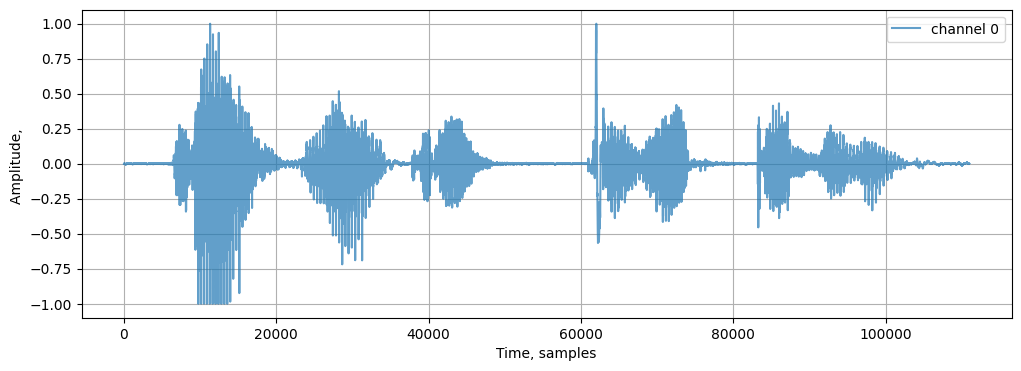

In [70]:
visualize_audio(AUDIO_DIR / "example_mono_123_hello.wav")

А вот, как выглядит звук в формате стерео:

Sample rate: 22050
Num samples: 201066
Duration: 9.119


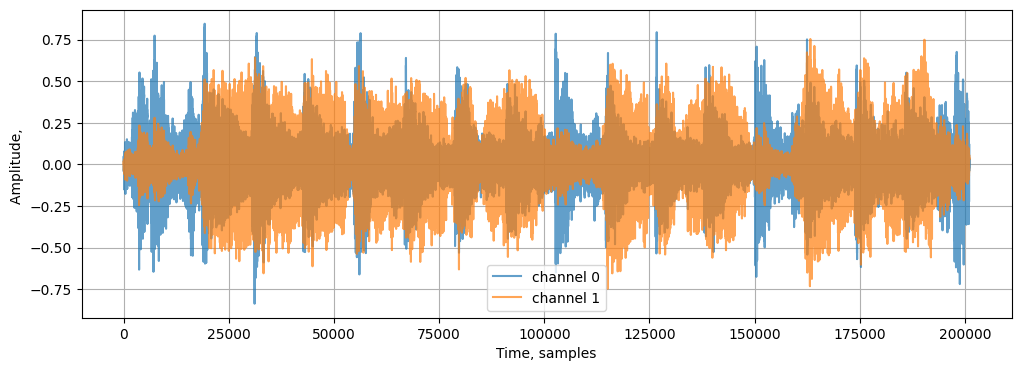

In [71]:
visualize_audio(AUDIO_DIR / "example_stereo_yellow_submarine.wav")

Тут мы видим два сигнала. Давайте послушаем каждый в отдельности.

In [72]:
wav_stereo, sr_stereo = torchaudio.load(AUDIO_DIR / "example_stereo_yellow_submarine.wav", normalize=True)

display(Audio(data=wav_stereo[0].unsqueeze(0), rate=sr_stereo))  # первый канал
display(Audio(data=wav_stereo[1].unsqueeze(0), rate=sr_stereo))  # второй канал

#### А если я не хочу писать код?

```shell
apt-get update
apt-get install mediainfo
mediainfo ./data/audio/example_mono_123_hello.wav
```

#### Ресэмплинг

Оказывается, что частоту сэмплирования одного и того же аудио можно менять по своему желанию. Процедура, которая позволяет это сделать называется **ресэмплингом** (resampling).

Ресэмплинг можно провести в две стороны. Если вкратце, то вот, что происходит под капотом:
1. В меньшую сторону (downsampling) -- фильтруем высокие частоты и производим "прореживание" (децимацию) сигнала.
2. В большую сторону (upsampling) -- интерполируем сигнал.

Далее произведем ресэмплинг аудио 44.1 кГц в 16 кГц:

In [73]:
resampler_44k_to_16k = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
wav_16k = resampler_44k_to_16k(wav)
sr_16k = 16000

print(wav_16k.shape)
display(Audio(data=wav_16k, rate=16000))

torch.Size([1, 40278])


Уйдем ещё ниже:

In [31]:
resampler_44k_to_8k = torchaudio.transforms.Resample(orig_freq=sr, new_freq=8000)
wav_8k = resampler_44k_to_8k(wav)

print(wav_8k.shape)
display(Audio(data=wav_8k, rate=8000))

torch.Size([1, 20139])


А теперь попробуем восстановить:

In [32]:
resampler_8k_to_44k = torchaudio.transforms.Resample(orig_freq=8000, new_freq=sr)
wav_44k_recovered = resampler_8k_to_44k(wav_8k)

print(wav_44k_recovered.shape)
display(Audio(data=wav_44k_recovered, rate=44100))

torch.Size([1, 111017])


#### *Полезно*: Какую частоту сэмплирования выбрать при оцифровке звука?

В области цифровой обработки сигналов существует фундаментальное утверждение:
> Если найти максимальную частоту $f_{max}$ сигнала и умножить на 2, то полученное значение будет минимальной частотой сэмплирования, с которой необходимо оцифровать сигнал, если мы потом захотим восстановить его без потерь.

Утверждение называется **теоремой Котельникова**, а полученная частота сэмплирования -- это **частота Найквиста**.

*Краевой случай 1.*<br>
Основной тон человеческой речи (самая маленькая частота) колеблется в диапазоне от 80 до 500 Гц. Чтобы его закодировать без потерь нам нужна частота сэмплирования 500 * 2 = 1 кГц.

*Краевой случай 2.*<br>
Человеческое ухо воспринимает частоты в диапазоне от 20 до 20000 Гц. Чтобы без потерь оцифровать соответствующий сигнал нам необходима частота сэмплирования 20000 * 2 = 40 кГц.

Как было описано ранее, при даунсэмплинге -- ценой уменьшения объема данных -- мы теряем информацию о высоких частотах.<br>Для задач анализа это не должно быть камнем преткновения -- даже на 8кГц речь весьма членораздельна. Поэтому тут часто можно встретить такие частоты, как 8 и 16 кГц.<br>С другой стороны для задач синтеза высокая частота сэмплирования становится важным критерием т.к. получаемый звук зачастую не должен содержать в себе артефактов. Из-за чего использование звука в 22.05 или 44.1 кГц будет предпочтительнее в этой области.

### **Часть 2. Как извлечь признаки?**

В лекции было рассказано, что использование сырого сигнала для нейронных моделей было бы кощунственно с точки зрения расходов по памяти.<br>По этой причине были введены понятия **кратковременного преобразования Фурье** и последующее извлечение **mel-спектра**.

Далее мы рассмотрим их извлечение на 16 кГц сигнале с помощью `torchaudio`.

In [59]:
def plot_waveform_and_spec(wav: torch.Tensor, spec: torch.Tensor, spec_title: str):
    fig, axes = plt.subplots(2, 1)
    axes[0].plot(wav[0], alpha=0.7)
    axes[0].set_title("WaveForm сигнала")
    axes[1].imshow(spec[0], origin="lower", aspect="auto", interpolation="nearest")
    axes[1].set_title(spec_title)
    fig.tight_layout()

#### STFT

Напишем код того, как мы извлекаем спектрограмму (матрицу STFT).

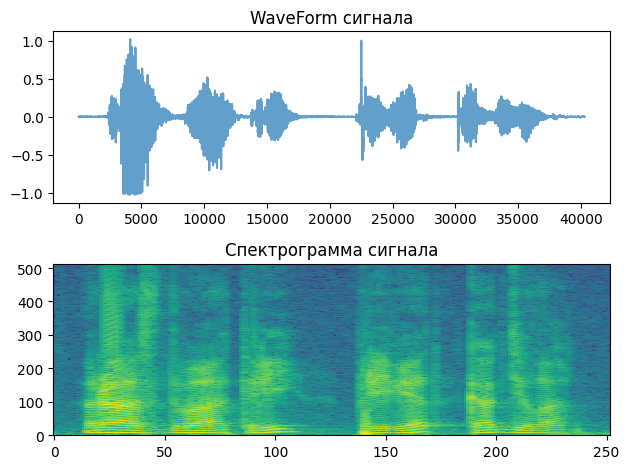

In [75]:
stft_extractor = torch.nn.Sequential(
    torchaudio.transforms.Spectrogram(
        n_fft=1024,
        hop_length=int(sr_16k * 0.01)
    ),
    torchaudio.transforms.AmplitudeToDB()
)
stft = stft_extractor(wav_16k)

plot_waveform_and_spec(wav_16k, stft, "Спектрограмма сигнала")

#### Mel-spectrogram

Теперь извлечем мел-спектрограмму.

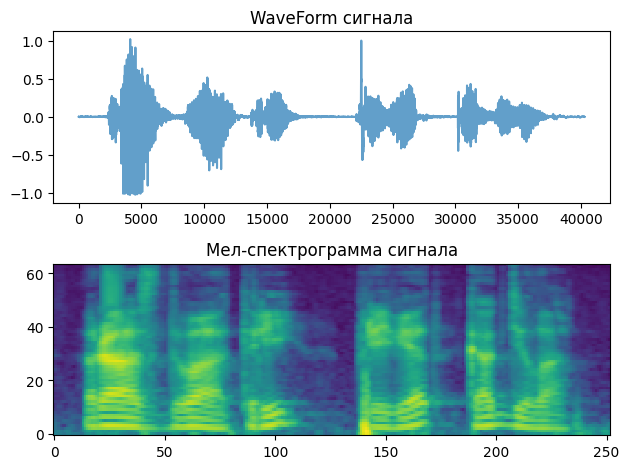

In [61]:
mel_extractor = torch.nn.Sequential(
    torchaudio.transforms.MelSpectrogram(
        n_mels=64,
        n_fft=1024, 
        hop_length=int(sr_16k * 0.01),
    ),
    torchaudio.transforms.AmplitudeToDB()
)
mels = mel_extractor(wav_16k)

plot_waveform_and_spec(wav_16k, mels, "Мел-спектрограмма сигнала")

#### *Полезно*: извлекаем более компактные признаки -- MFCC

Мел-спектр -- это не предел возможностей оптимизации признаков для дальнейшего анализа нейросетью.<br>Внимательный зритель заметил, что на мел-спектре есть сильно скореллированные компоненты. Речь идёт о горизонтальных спектральных полосах в моменты времени, когда в звукоизвлечением занимались голосовые связки. Это те самые форманты, о которых говорилось в лекции.<br>*Можно ли их как-то "схлопнуть"?*

Да, можно.<br>При помощи извлечения мел-частотных кепстральных коэффициентов (mel-frequency cepstral coefficients, MFCC).

С точки зрения алгоритма, для перехода `MelSpec -> MFCCs` нам нужно сделать лишь две вещи:
1. Дополнительно "сжать" спектр с помощью [дискретного косинусного преобразования](https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D1%81%D0%BA%D1%80%D0%B5%D1%82%D0%BD%D0%BE%D0%B5_%D0%BA%D0%BE%D1%81%D0%B8%D0%BD%D1%83%D1%81%D0%BD%D0%BE%D0%B5_%D0%BF%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5).
2. Из полученного результата взять только первые `n` компонент.

Мы не пойдём сложным путём изучения формул, а просто применим пару функций `torchaudio`:

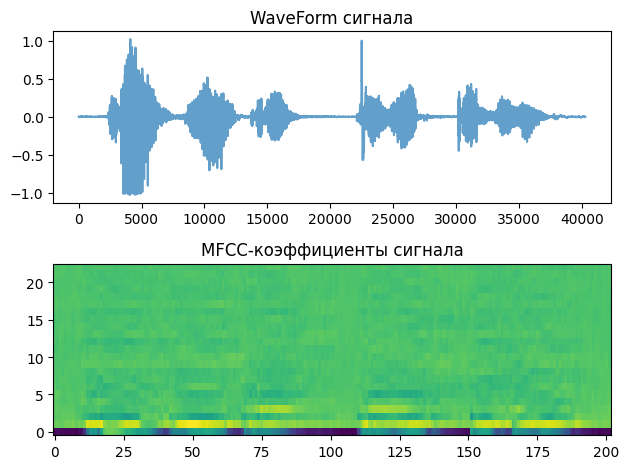

In [63]:
mfcc_extractor = torchaudio.transforms.MFCC(n_mfcc=23)
mfccs = mfcc_extractor(wav_16k)

plot_waveform_and_spec(wav_16k, mfccs, "MFCC-коэффициенты сигнала")

Полученный сигнал небогат, но подойдёт для таких задач, как детекция речевой активности (Voice Activity Detection, VAD)

### **Часть 3. Как накладывать аугментации?**

На практике любой речевой сигнал "загрязнён". Его качество зависит от множества факторов, в т.ч. описываемыми условиями окружающей среды, каналами связи и передачи данных.
Чтобы приблизить сигнал к тому, как он может звучать в реальности, применяют техники искусственного увеличения данных.

В этом разделе мы просмотрим, как именно мы можем исказить данные с помощью простых аугментаций.

Разберём наложение фоновых шумов, речи, ревербераций. Узнаем, что такое спектральная аугментация.

#### Наложение случайного шума

Наложение любого сигнала "поверх" изучаемого является аддитивной процедурой. Иными словами, для создания смеси звучания двух сигналов достаточно их поэлементно сложить.

Проиллюстрируем это на примере наложения сигнала шума Гаусса.

In [84]:
def add_white_noise(wav: torch.Tensor, noise_amplitude: float = 0.01) -> torch.Tensor:
    # Генерируем белый шум и накладываем на сигнал
    noise = torch.randn_like(wav_16k)
    wav_noised = wav + noise_amplitude * noise

    return wav_noised

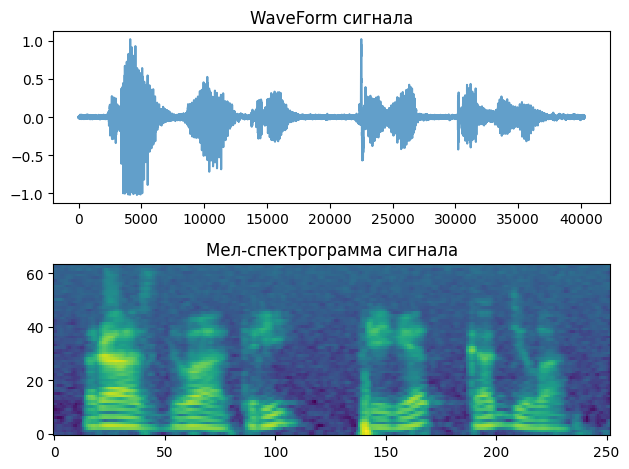

In [85]:
# Применяем функцию 
wav_16k_noised = add_white_noise(wav_16k)

# Извлекаем мел-спектр (для пущей иллюстративности)
mel_noised = mel_extractor(wav_16k_noised)

# Выводим результаты
display(Audio(data=wav_16k_noised, rate=16000))
plot_waveform_and_spec(wav_16k_noised, mel_noised, "Мел-спектрограмма сигнала")

#### Наложение фоного шума

Отдельного внимания стоит функционал наложения естественного фонового шума (например, людный торговый центр или щебет птиц в парке).

Со стороны кажется, что наложить естественный шум на сигнал можно ровно таким же образом, что и случайный. Однако, стоит учесть, что фоновый шум должен быть тем ниже, чем ниже общая мощность исходного сигнала.

Из-за этого возникает необходимость каким-то образом динамически регулировать амплитуду шума в зависимости от амплитуды исходного сигнала.

Здесь вводится понятие отношение "сигнал-шум" (signal-to-noise ratio, SNR):<br><br>
$$
SNR_{db}=10*log_{10}(\frac{P_{signal}}{P_{noise}})
$$

где $P_{signal}$ и $P_{noise}$ -- это мощности сигнала и шума, которые считаются как средний квадрат амплитуды сигнала: <br><br>

$$
P = E[A^2]
$$

Применим всё сказанное выше для создания функции "динамического" наложения фонового шума:

In [ ]:
def add_background_noise(wav: torch.Tensor, noise_wav: torch.Tensor, snr_db: float = 3.0) -> torch.Tensor:
    wav_power = torch.mean(wav ** 2, dim=0)
    noise_power = torch.mean(wav ** 2, dim=0)

    snr = wav_power / noise_power
    snr_target = wav_power / x